In [32]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Load Data

In [22]:
metrics = pd.read_csv(
    "../metrics.csv"
)
metrics = metrics[metrics["split_path"] == "cv_split_base_and_prev_comps_XCsnipet28032025_group_allbirds_hdf5.npy"].reset_index(drop=True)
metrics = metrics[metrics["Public"] > 0.7].reset_index(drop=True)

metrics["Folds Roc AUC"] = metrics["Folds Roc AUC"].apply(eval) 

# Utils

In [23]:
def plot_score_correlation(df, leaderboard_col, local_val_col, figsize=(8, 6)):
    """
    Plots a scatter plot of local validation scores vs leaderboard scores.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        leaderboard_col (str): Column name for leaderboard scores.
        local_val_col (str): Column name for local validation scores.
        figsize (tuple): Size of the figure.
    """
    x = df[local_val_col]
    y = df[leaderboard_col]
    
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7)
    plt.plot([x.min(), x.max()], [y.min(), y.max()], color='red', linestyle='--', label='y = x')
    
    plt.xlabel(local_val_col)
    plt.ylabel(leaderboard_col)
    plt.title('Correlation between Local Validation and Leaderboard Scores')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

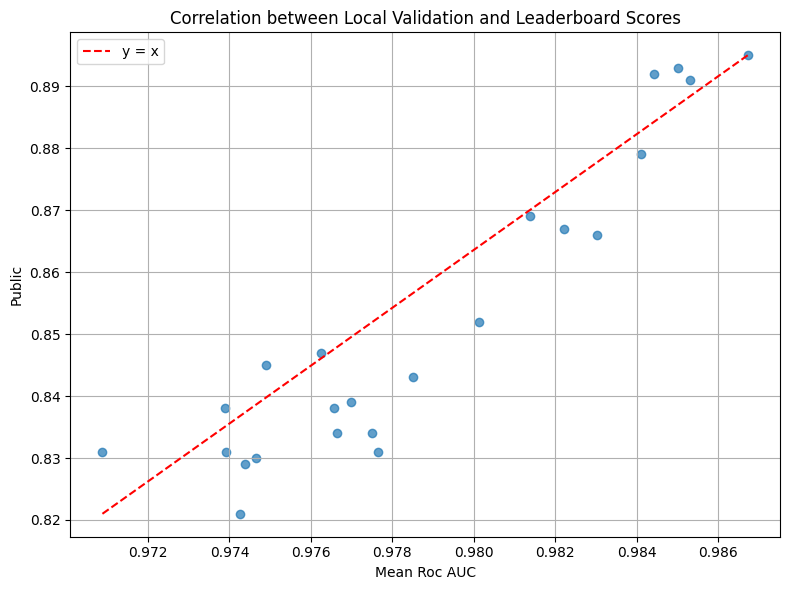

In [24]:
plot_score_correlation(
    df=metrics,
    local_val_col="Mean Roc AUC",
    leaderboard_col="Public"
)

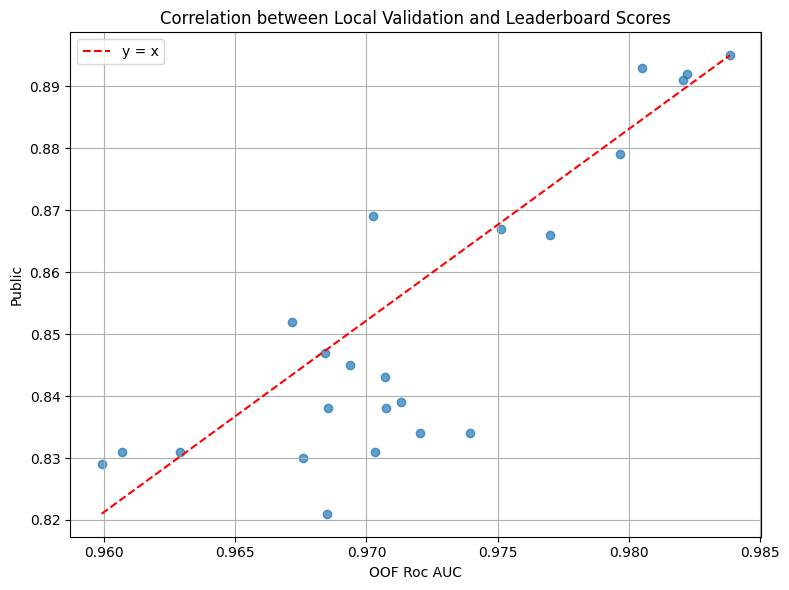

In [25]:
plot_score_correlation(
    df=metrics,
    local_val_col="OOF Roc AUC",
    leaderboard_col="Public"
)

In [26]:
def plot_fold_auc_individual_histograms(df, fold_auc_col, bins=20, figsize=(8, 3)):
    """
    Plots individual histograms of ROC AUCs per fold in a vertical column layout,
    and prints useful statistics for each fold including mean, std, min, max, IQR, and median.

    Args:
        df (pd.DataFrame): DataFrame containing the fold AUC scores.
        fold_auc_col (str): Column name with List[float] per row (e.g., ROC AUCs per fold).
        bins (int): Number of bins for histograms.
        figsize (tuple): Size of each subplot (width, height).
    """
    fold_values = df[fold_auc_col].dropna().tolist()
    n_folds = max(len(folds) for folds in fold_values)

    # Collect AUCs per fold
    per_fold_aucs = [[] for _ in range(n_folds)]
    for folds in fold_values:
        for i, auc in enumerate(folds):
            per_fold_aucs[i].append(auc)

    # Create vertical subplots
    fig, axs = plt.subplots(n_folds, 1, figsize=(figsize[0], figsize[1] * n_folds))

    for i, (fold_aucs, ax) in enumerate(zip(per_fold_aucs, axs)):
        ax.hist(fold_aucs, bins=bins, alpha=0.75, edgecolor='black')
        ax.set_title(f'Fold {i} Histogram')
        ax.set_xlabel('ROC AUC')
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print stats
    print("\nFold-wise Statistics:")
    for i, fold_aucs in enumerate(per_fold_aucs):
        fold_aucs = np.array(fold_aucs)
        mean = fold_aucs.mean()
        std = fold_aucs.std()
        median = np.median(fold_aucs)
        q1 = np.percentile(fold_aucs, 25)
        q3 = np.percentile(fold_aucs, 75)
        iqr = q3 - q1
        print(
            f"Fold {i}: "
            f"mean={mean:.4f}, std={std:.4f}, median={median:.4f}, "
            f"min={fold_aucs.min():.4f}, max={fold_aucs.max():.4f}, IQR={iqr:.4f}"
        )


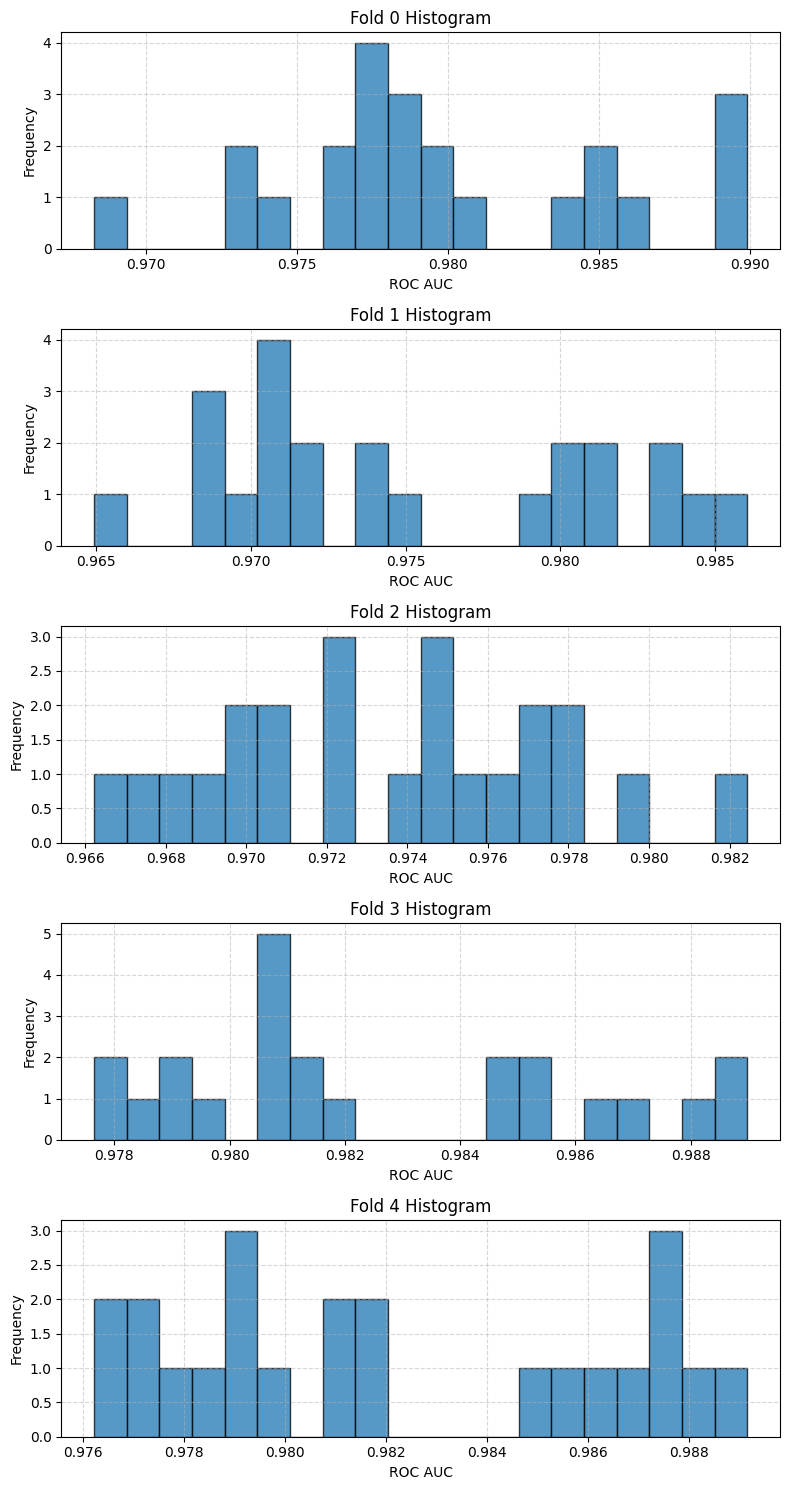


Fold-wise Statistics:
Fold 0: mean=0.9798, std=0.0055, median=0.9789, min=0.9683, max=0.9899, IQR=0.0078
Fold 1: mean=0.9753, std=0.0062, median=0.9738, min=0.9649, max=0.9860, IQR=0.0104
Fold 2: mean=0.9735, std=0.0041, median=0.9737, min=0.9662, max=0.9824, IQR=0.0062
Fold 3: mean=0.9826, std=0.0035, median=0.9814, min=0.9776, max=0.9890, IQR=0.0052
Fold 4: mean=0.9822, std=0.0042, median=0.9813, min=0.9762, max=0.9891, IQR=0.0077


In [27]:
plot_fold_auc_individual_histograms(
    df=metrics,
    fold_auc_col="Folds Roc AUC",
)

# Pick Best Models

In [28]:
metrics[metrics["exp_name"].apply(lambda x: "From" not in x)].sort_values("Public", ascending=False).iloc[0].to_dict()

{'exp_name': 'tf_efficientnetv2_s_in21k_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SR22050_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_GenUni',
 'chkp_name': 'Best',
 'comment': '5 sec train audio pred',
 'split_path': 'cv_split_base_and_prev_comps_XCsnipet28032025_group_allbirds_hdf5.npy',
 'Mean Roc AUC': 0.976244761915223,
 'OOF Roc AUC': 0.9684037699218097,
 'Folds Roc AUC': [0.9783624634846105,
  0.9704733839835663,
  0.9722520014221796,
  0.9809371944652365,
  0.9791987662205215],
 'Public': 0.847,
 'Public comment': 'Openvino FP16 + 5 Folds Mean'}

In [29]:
metrics.set_index("exp_name").sort_values("Public", ascending=False)["Public"]

exp_name
eca_nfnet_l0_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SpecAugV1_FocalBCELoss_LSF1005_5Folds_ScoredPrevCompsAndXCsnipet28032025_FromV2Y2025Last_PseudoF1PT05MT01P04    0.895
eca_nfnet_l0_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_FromV2Y2025Last_PseudoV1PT05MT01P04            0.893
eca_nfnet_l1_Exp_DPR02_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_FromV2Y2025Last_PseudoV2PT05MT01P05            0.892
eca_nfnet_l1_Exp_DPR02_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_FromV2Y2025Last_PseudoV1PT05

# Out Of Fold Predictions

In [31]:
!ls /gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/predictions/ -lt

total 15
drwxr-sr-x 2 volodymyr1 BetterMedicine 4096 Apr 23 17:27 tf_efficientnetv2_s_in21k_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SR22050_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_GenUni
drwxr-sr-x 2 volodymyr1 BetterMedicine 4096 Apr 23 17:27 tf_efficientnetv2_s_in21k_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SR22050_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_GenFilOver
drwxr-sr-x 2 volodymyr1 BetterMedicine 4096 Apr 22 15:57 tf_efficientnetv2_s_in21k_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_AdamW1e4_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_FromV2Y2025Last
drwxr-sr-x 2 volodymyr1 BetterMedicine 4096 Apr 22 15:56 eca_nfnet_l1_Exp_DPR02_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_R

In [48]:
import json

from typing import Mapping, Any

def load_json(path: str) -> Mapping[str, Any]:
    """
    Read .json file and return dict
    """
    with open(path, "r") as read_file:
        loaded_dict = json.load(read_file)
    return loaded_dict

In [34]:
EXP_NAME = "tf_efficientnetv2_s_in21k_Exp_noamp_64bs_5sec_mixupP05_RandomFiltering_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_BackGroundSoundScapeORESC50P05_SR22050_SpecAugV1_FocalBCELoss_5Folds_ScoredPrevCompsAndXCsnipet28032025_GenUni"

In [72]:
full_train_df = pd.read_csv(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_and_prev_comps_extendedv1_pruneSL_XConly2025_snipet28032025_hdf5.csv",
    converters={"secondary_labels": eval}
)
cv_split = np.load(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/cv_split_base_and_prev_comps_XCsnipet28032025_group_allbirds_hdf5.npy",
    allow_pickle=True
)
scored_birds = load_json(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/sb_2025.json"
)
int2bird = {k:v for k,v in enumerate(scored_birds)}

In [74]:
fold_dfs = [
    full_train_df.iloc[cv_split[i][1]].reset_index(drop=True) for i in range(len(cv_split))
]

In [75]:
def one_hot_conversion(
    primary_label,
    secondary_labels,
    mapping,
):
    all_labels = set([primary_label] + secondary_labels)
    return np.array([int(mapping[i] in all_labels) for i in range(len(mapping))])

In [76]:
np.stack(fold_dfs[0].apply(lambda row: one_hot_conversion(row["primary_label"], row["secondary_labels"], int2bird), axis=1).values)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [77]:
# Refers to One Hot Ground Truth Labels
# Shape List of size N (5) Folds, where each element [N_samples_in_fold, N_birds (206)]
# Type int
val_tgts = np.load(
    os.path.join("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/predictions/", EXP_NAME, "tgts.npy"),
    allow_pickle=True
)
# Refers to Predicted Probabilities in OOF manner
# Shape List of size N (5) Folds, where each element [N_samples_in_fold, N_birds (206)]
# Type float in [0, 1] range
val_preds = np.load(
    os.path.join("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/predictions/", EXP_NAME, "preds.npy"),
    allow_pickle=True
)

In [78]:
# Validate that val_tgts match fold dfs labels
for i in range(len(cv_split)):
    assert np.allclose(
        np.stack(fold_dfs[i].apply(lambda row: one_hot_conversion(row["primary_label"], row["secondary_labels"], int2bird), axis=1).values),
        val_tgts[i]
    )